tgb - 5/18/2020 - Spectral enthalpy budget building on:  
1. [https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL084130] for its formulation  
2. [https://github.com/tbeucler/2019_WMI/blob/master/dev/tbeucler/004_Landau_Surface_Tension.ipynb] for some utilities to facilitate plotting    
3. [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/018_Water_budget_diagnostics.ipynb] to close the local enthalpy budget in SPCAM3. May not need it if investigating zonal structure of coarse-scale MSE as a first step.  

# Initialization

## Import python libraries

In [1]:
import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as sin

## Figure properties

In [2]:
fz = 15
lw = 4

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

## Load dataset

Load a month of SPCAM3 data using xarray

In [3]:
path_sim = '/beegfs/DATA/pritchard/srasp/sp32fbp_andkua/' # Path to 32-col SPCAM3 aquaplanet simulation data
data = xr.open_mfdataset(path_sim+'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0001-01-*')

List data attributes

In [4]:
data

<xarray.Dataset>
Dimensions:       (crm_x: 32, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 1488)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 ... 112.0 116.0 120.0 124.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) object 0001-01-01 00:00:00 ... 0001-01-31 23:30:00

# Estimate terms of column MSE budget

tgb - 5/18/2020 - Rough estimate with advection of MSE estimated as a residual from the budget. Meant as an example for more extensive tests on E3SM data.

## Estimate column MSE from three-dimensional variables

Building on geopotential estimates for Noah Brenowitz in [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/021_Jacobians_for_Noah.ipynb]

In [5]:
# Ideal gas law -> rho=p(R_d*T_v)
C_P = 1.00464e3 # Specific heat capacity of dry air at constant pressure
eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
G = 9.81 # Gravity constant
L_V = 2.501e6   # Latent heat of vaporization of water at standard atmospheric T & p
R_D = 287 # Specific gas constant of dry air in J/K/kg

r = data.QAP/(data.QAP**0-data.QAP)
Tv = data.TAP*(r**0+r/eps)/(r**0+r)
rho = 1e2*data.lev/(R_D*Tv)
rho = np.moveaxis(rho.values,1,0)

z = -sin.cumtrapz(x=1e2*data.lev.values,y=1/(G*rho),axis=1)
z = np.concatenate((np.zeros((z.shape[0],1,z.shape[2],z.shape[3])),z),axis=1)
z = z-z[:,[-1],:,:]

Text(0, 0.5, 'Background pressure [hPa]')

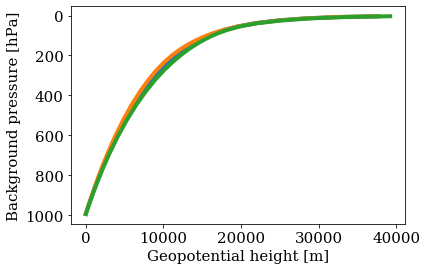

In [6]:
plt.plot(np.mean(z,axis=(0,2,3)),data.lev)
plt.plot(np.percentile(z,25,axis=(0,2,3)),data.lev)
plt.plot(np.percentile(z,75,axis=(0,2,3)),data.lev)
plt.gca().invert_yaxis()
plt.xlabel('Geopotential height [m]')
plt.ylabel('Background pressure [hPa]')

In [7]:
mse = L_V*data.QAP+C_P*data.TAP+G*z # Local MSE 

Text(0, 0.5, 'Background pressure [hPa]')

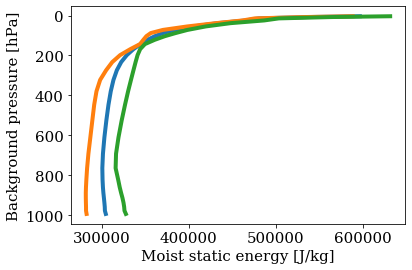

In [8]:
plt.plot(np.mean(mse,axis=(0,2,3)),data.lev)
plt.plot(np.percentile(mse,25,axis=(0,2,3)),data.lev)
plt.plot(np.percentile(mse,75,axis=(0,2,3)),data.lev)
plt.gca().invert_yaxis()
plt.xlabel('Moist static energy [J/kg]')
plt.ylabel('Background pressure [hPa]')

Column MSE assuming that the background pressure is hydrostatic

In [9]:
MSE = sin.trapz(x=1e2*data.lev.values/G,y=mse,axis=1)

In [10]:
MSE.shape

(1488, 64, 128)

Create time coordinate

In [11]:
dt = 1800; # Timestep in seconds
tcoor = dt*np.arange(0,data.time.shape[0])

Plot conditionally-averaged MSE as a function of latitude, longitude, and time

Text(0.5, 0, 'Time [day]')

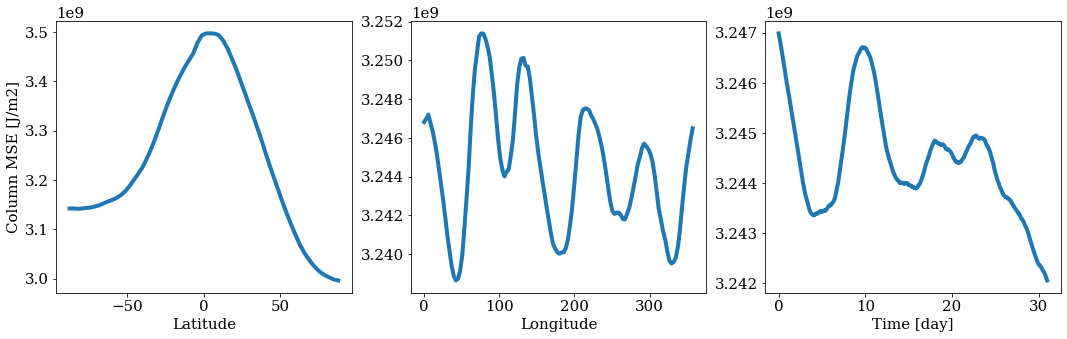

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,5))

ax[0].plot(data.lat,np.mean(MSE,axis=(0,2)))
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Column MSE [J/m2]')

ax[1].plot(data.lon,np.mean(MSE,axis=(0,1)))
ax[1].set_xlabel('Longitude')

ax[2].plot(tcoor/(24*3600),np.mean(MSE,axis=(1,2)))
ax[2].set_xlabel('Time [day]')

## Estimate time-tendency of MSE

In [13]:
t_range = np.arange(0,np.size(data.time)-2)
dMSE_dt = (MSE[t_range+2,:,:]-MSE[t_range,:,:])/(2*dt)

## Estimate MSE advection as residual of column MSE budget

In [14]:
data.FLNS.mean().values

array(50.23401, dtype=float32)

In [15]:
data.FLNT.mean().values

array(224.87924, dtype=float32)

In [16]:
data.FSNS.mean().values

array(159.7535, dtype=float32)

In [17]:
data.FSNT.mean().values

array(227.18353, dtype=float32)

In [18]:
data.SHFLX.mean().values

array(15.9253845, dtype=float32)

In [19]:
data.LHFLX.mean().values

array(71.66172, dtype=float32)

In [20]:
LW = (data.FLNS-data.FLNT)[t_range+1,:,:]  # Longwave heating [W/m2]
SW = (data.FSNT-data.FSNS)[t_range+1,:,:] # Shortwave heating [W/m2]
SEF = (data.SHFLX+data.LHFLX)[t_range+1,:,:] # Surface enthalpy fluxes [W/m2]

In [21]:
ADV = dMSE_dt-LW-SW-SEF # MSE advection calculated as residual

Group all terms in budget terms' structure

In [22]:
BUD = {}
BUD['Longwave'] = LW
BUD['Shortwave'] = SW
BUD['Surface fluxes'] = SEF
BUD['Advection'] = ADV
BUD['MSE Tendency'] = dMSE_dt

Text(0.5, 0, 'Time [day]')

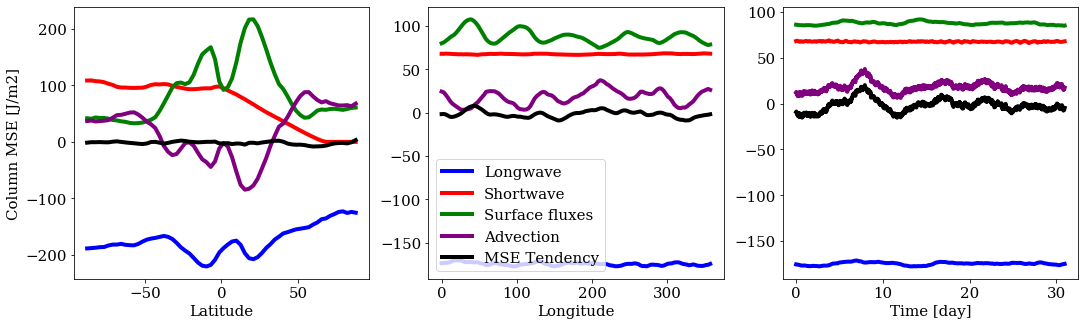

In [23]:
colors = ['b','r','g','purple','k']

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,5))

for ivar,var in enumerate(BUD.keys()):
    ax[0].plot(data.lat,np.mean(BUD[var],axis=(0,2)),label=var,color=colors[ivar])
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Column MSE [J/m2]')

for ivar,var in enumerate(BUD.keys()):
    ax[1].plot(data.lon,np.mean(BUD[var],axis=(0,1)),label=var,color=colors[ivar])
ax[1].set_xlabel('Longitude')
ax[1].legend()

for ivar,var in enumerate(BUD.keys()):
    ax[2].plot(tcoor[t_range+1]/(24*3600),np.mean(BUD[var],axis=(1,2)),label=var,color=colors[ivar])
ax[2].set_xlabel('Time [day]')

# Zonal spectra

## Define wavenumber and wavelength

Here, we will consider a range of latitudes centered around the Equator and approximate our domain as locally cartesian with constant zonal spacing x (only valid for tight range of latitudes)

In [24]:
erad = 6.3781e3 # Approximate Earth radius [km]

In [25]:
ilatS = np.argmin(np.abs(data.lat+20)).values
ilatN = np.argmin(np.abs(data.lat-20)).values
ilat_range = np.arange(ilatS,ilatN)

In [26]:
ilat_range

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38])

Average dx on a spherical grid

In [27]:
dx = erad*np.deg2rad(data.lon[1]-data.lon[0])*\
(np.sin(np.deg2rad(data.lat[ilatN]))-np.sin(np.deg2rad(data.lat[ilatS])))/\
(np.deg2rad(data.lat[ilatN])-np.deg2rad(data.lat[ilatS]))

In [28]:
data.lon.shape[0]-1

127

In [29]:
x = dx.values*np.arange(0,data.lon.shape[0]-1)

Exact y assuming Spherical Earth

In [30]:
y = erad*np.deg2rad(data.lat)

Create wavenumber and wavelength vectors

In [31]:
Nx = np.size(x)
k = np.arange(start=0,stop=(2*np.pi)/(2*dx),step=(2*np.pi)/(Nx*dx)); 
Nk = np.size(k);
lam = 2*np.pi/k
dok = np.arange(1,Nk-1); # Index restriction to exclude k=0

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


## Zonal spectrum of MSE

The calculation of the MSE's power spectrum is very quick with the fft library (one to two lines). It is better to calculate the zonal spectrum at each timestep and each latitude separately, and then take the average after calculating the quantity of interest (e.g., power spectrum, covariance, etc.)

In [40]:
F_MSE = fft.fft(MSE,axis=2) # Zonal Fourier transform of column MSE
phi = np.abs(F_MSE[:,:,dok])**2 # Zonal power spectrum of column MSE

Diagnostics plots start here

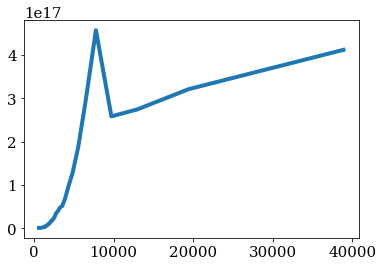

In [41]:
plt.plot(lam[dok],np.mean(phi[:,ilatS:ilatN,:],axis=(0,1)))

Text(0.5, 1.0, 'Average over January and 20S to 20N')

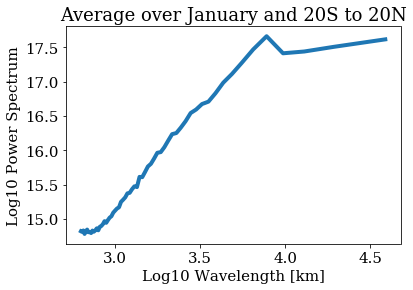

In [42]:
plt.plot(np.log10(lam[dok]),np.log10(np.mean(phi[:,ilatS:ilatN,:],axis=(0,1))))
plt.xlabel('Log10 Wavelength [km]')
plt.ylabel('Log10 Power Spectrum')
plt.title('Average over January and 20S to 20N')

Text(0.5, 1.0, 'More small-scale variability in the Tropics')

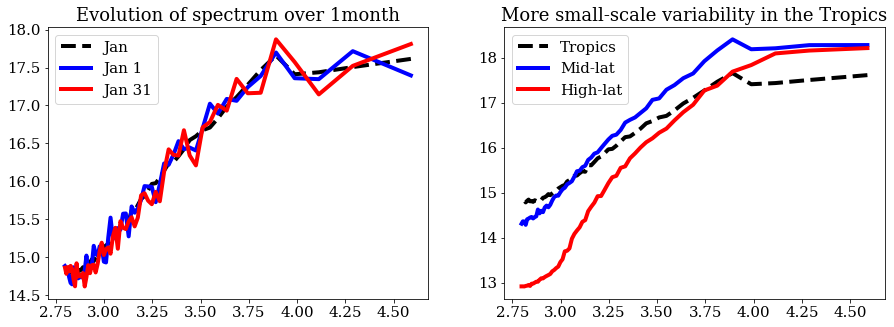

In [47]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

ax[0].plot(np.log10(lam[dok]),np.log10(np.mean(phi[:,ilatS:ilatN,:],axis=(0,1))),color='k',linestyle='--',label='Jan')
ax[0].plot(np.log10(lam[dok]),np.log10(np.mean(phi[:48,ilatS:ilatN,:],axis=(0,1))),color='b',label='Jan 1')
ax[0].plot(np.log10(lam[dok]),np.log10(np.mean(phi[-48:,ilatS:ilatN,:],axis=(0,1))),color='r',label='Jan 31')
ax[0].legend()
ax[0].set_title('Evolution of spectrum over 1month')

ax[1].plot(np.log10(lam[dok]),np.log10(np.mean(phi[:,ilatS:ilatN,:],axis=(0,1))),color='k',linestyle='--',label='Tropics')
ax[1].plot(np.log10(lam[dok]),np.log10(np.mean(phi[:,38:50,:],axis=(0,1))),color='b',label='Mid-lat')
ax[1].plot(np.log10(lam[dok]),np.log10(np.mean(phi[:,50:,:],axis=(0,1))),color='r',label='High-lat')
ax[1].legend()
ax[1].set_title('More small-scale variability in the Tropics')

## Zonal spectral MSE budget

Calculate the creation of MSE zonal variance at each zonal wavelength by each MSE budget term

Follows this equation:

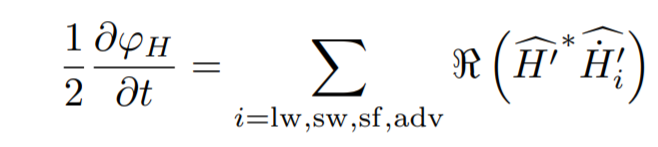

in [https://arxiv.org/pdf/1908.03764.pdf]

In [49]:
SPBUD = {}
for ivar,var in enumerate(BUD.keys()):
    SPBUD[var] = 2*np.real(np.conj(fft.fft(BUD[var],axis=2))*F_MSE[1:-1,:,:])[:,:,dok]

To plot it, it is convenient to divide by the power spectrum to yield growth rate units (1/time), following this equation:

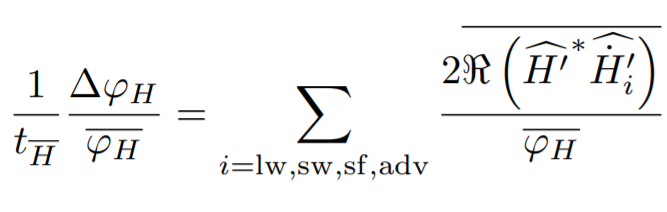

Text(0.5, 1.0, 'Contribution of each budget term to scale-by-scale change in col. MSE variance')

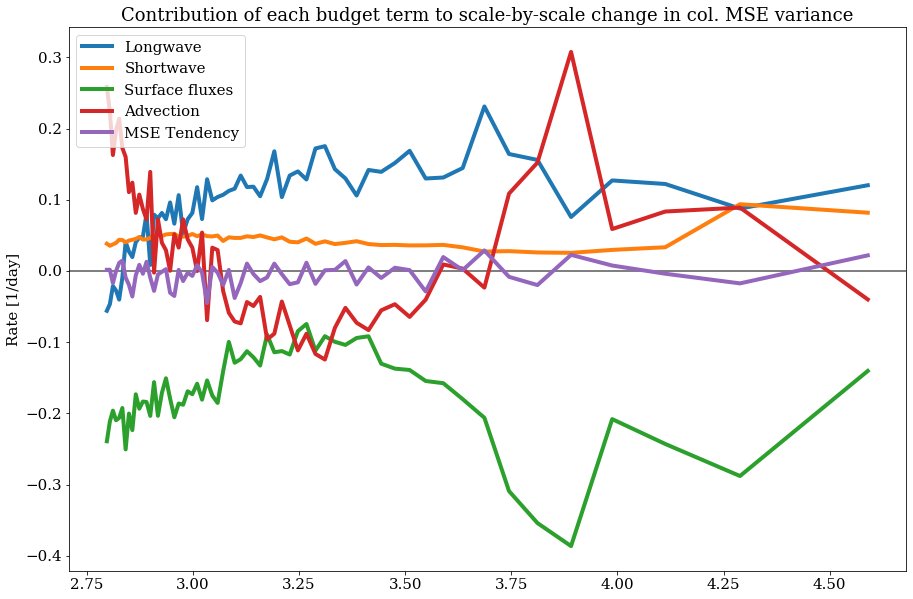

In [68]:
plt.figure(figsize=(15,10))

for ivar,var in enumerate(BUD.keys()):
    plt.plot(np.log10(lam[dok]),\
             24*3600*np.mean(SPBUD[var][:,ilatS:ilatN,:],axis=(0,1))/np.mean(phi[:,ilatS:ilatN,:],axis=(0,1)),\
             label=var)
plt.legend(loc='upper left')
plt.axhline(y=0,zorder=0,color='gray',linewidth=lw/2)
plt.ylabel('Rate [1/day]')
plt.title('Contribution of each budget term to scale-by-scale change in col. MSE variance')

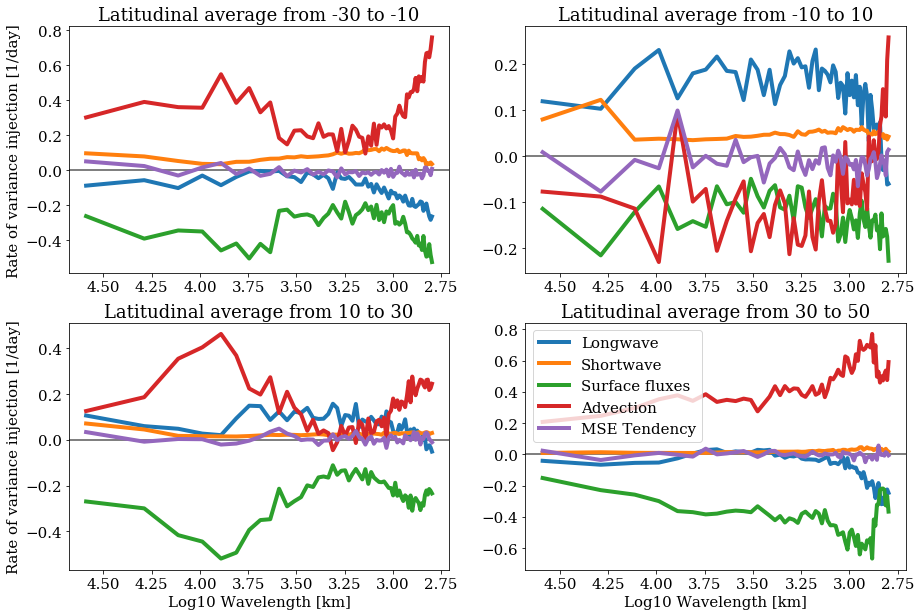

In [77]:
LATS = [-30,-10,10,30]
LATN = [-10,10,30,50]

fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

for ifig,ax0 in enumerate([ax[0][0],ax[0][1],ax[1][0],ax[1][1]]):
    
    ilatS = np.argmin(np.abs(data.lat-LATS[ifig])).values
    ilatN = np.argmin(np.abs(data.lat-LATN[ifig])).values
    
    for ivar,var in enumerate(BUD.keys()):
        ax0.plot(np.log10(lam[dok]),\
                 24*3600*np.mean(SPBUD[var][:,ilatS:ilatN,:],axis=(0,1))/\
                 np.mean(phi[:,ilatS:ilatN,:],axis=(0,1)),\
                 label=var)
        ax0.axhline(y=0,zorder=0,color='gray',linewidth=lw/2)
        ax0.set_title('Latitudinal average from '+str(LATS[ifig])+' to '+str(LATN[ifig]))
        if ifig==3: ax0.legend()
        if ifig==0 or ifig==2: ax0.set_ylabel('Rate of variance injection [1/day]')
        if ifig==2 or ifig==3: ax0.set_xlabel('Log10 Wavelength [km]')
        ax0.invert_xaxis()

In this SPCAM3 aquaplanet simulation, the surface enthalpy fluxes are a consistent sink of MSE variance at all wavelength. Longwave radiation seems to create variance at all wavelength in the deep Tropics, which then gets exported to higher latitudes through the advection term (sink of variance in the deep Tropics, source of variance everywhere else).   

We see that in SPCAM3, the injection rates are not red, which means that a lot of variance is injected at the CRM-scale in the model. It contrasts with GCRM and observational results (see below) where *in steady state*, most of the variance is injected at long wavelengths. 

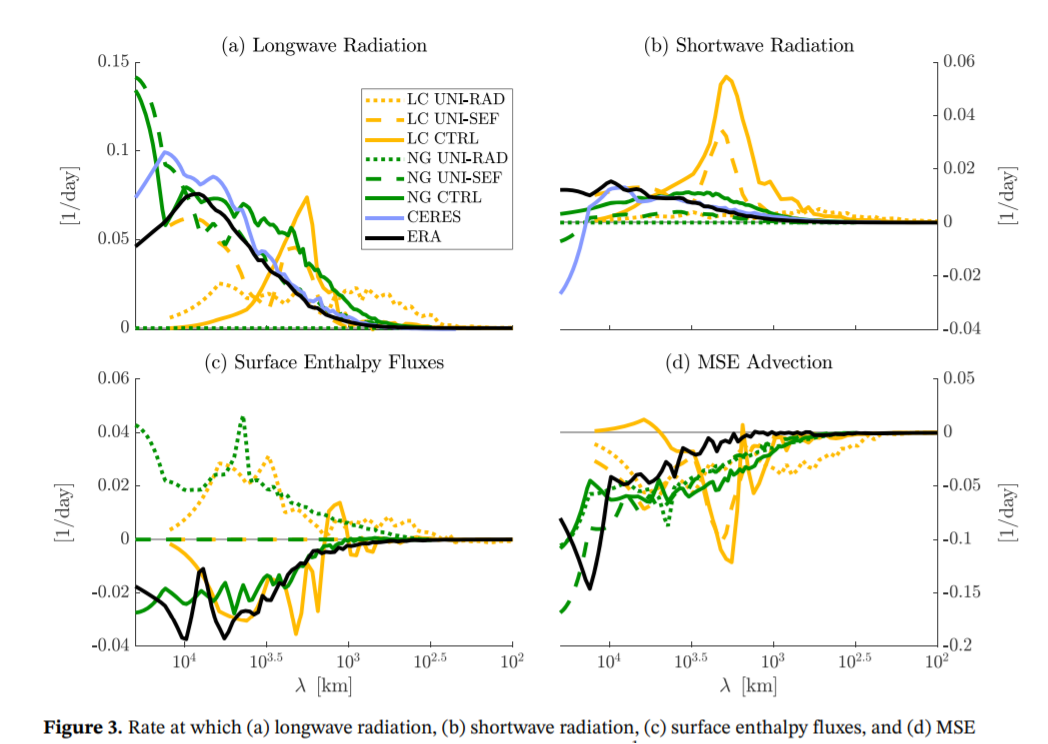